**Chapter 5 – Support Vector Machines**

_This notebook contains all the sample code and solutions to the exercises in chapter 5._

This notebook requires Python 3.7 or above:

In [7]:
from sklearn import datasets
from sklearn.datasets import fetch_california_housing
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, uniform
from sklearn.svm import LinearSVR
from sklearn.svm import SVR

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")
assert sys.version_info >= (3, 7)

In [5]:
IMAGES_PATH = "/home/silviojr/Documents/Courses/handson_ml3/my_folder/images/chapter_5_svm"
IMAGES_PATH = Path(IMAGES_PATH)
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Exercise solutions

## 1. to 8.

1. The fundamental idea behind Support Vector Machines is to fit the widest possible "street" between the classes. In other words, the goal is to have the largest possible margin between the decision boundary that separates the two classes and the training instances. When performing soft margin classification, the SVM searches for a compromise between perfectly separating the two classes and having the widest possible street (i.e., a few instances may end up on the street). Another key idea is to use kernels when training on nonlinear datasets. SVMs can also be tweaked to perform linear and nonlinear regression, as well as novelty detection.
2. After training an SVM, a _support vector_ is any instance located on the "street" (see the previous answer), including its border. The decision boundary is entirely determined by the support vectors. Any instance that is _not_ a support vector (i.e., is off the street) has no influence whatsoever; you could remove them, add more instances, or move them around, and as long as they stay off the street they won't affect the decision boundary. Computing the predictions with a kernelized SVM only involves the support vectors, not the whole training set.
3. SVMs try to fit the largest possible "street" between the classes (see the first answer), so if the training set is not scaled, the SVM will tend to neglect small features (see Figure 5–2).
4. You can use the `decision_function()` method to get confidence scores. These scores represent the distance between the instance and the decision boundary. However, they cannot be directly converted into an estimation of the class probability. If you set `probability=True` when creating an `SVC`, then at the end of training it will use 5-fold cross-validation to generate out-of-sample scores for the training samples, and it will train a `LogisticRegression` model to map these scores to estimated probabilities. The `predict_proba()` and `predict_log_proba()` methods will then be available.
5. All three classes can be used for large-margin linear classification. The `SVC` class also supports the kernel trick, which makes it capable of handling nonlinear tasks. However, this comes at a cost: the `SVC` class does not scale well to datasets with many instances. It does scale well to a large number of features, though. The `LinearSVC` class implements an optimized algorithm for linear SVMs, while `SGDClassifier` uses Stochastic Gradient Descent. Depending on the dataset `LinearSVC` may be a bit faster than `SGDClassifier`, but not always, and `SGDClassifier` is more flexible, plus it supports incremental learning.
6. If an SVM classifier trained with an RBF kernel underfits the training set, there might be too much regularization. To decrease it, you need to increase `gamma` or `C` (or both).
7. A Regression SVM model tries to fit as many instances within a small margin around its predictions. If you add instances within this margin, the model will not be affected at all: it is said to be _ϵ-insensitive_.
8. The kernel trick is mathematical technique that makes it possible to train a nonlinear SVM model. The resulting model is equivalent to mapping the inputs to another space using a nonlinear transformation, then training a linear SVM on the resulting high-dimensional inputs. The kernel trick gives the same result without having to transform the inputs at all.

# 9. LinearSVC, SVC and SGDClassifier

_Exercise: Train a `LinearSVC` on a linearly separable dataset. Then train an `SVC` and a `SGDClassifier` on the same dataset. See if you can get them to produce roughly the same model._

In [6]:
# We can generate a linearly separable dataset or we can use on that we know are linearly separable.
# Let's use the Iris dataset: the Iris Setosa and Iris Versicolor classes are linearly separable.

iris = datasets.load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

Now let's build and train 3 models:
* Remember that `LinearSVC` uses `loss="squared_hinge"` by default, so if we want all 3 models to produce similar results, we need to set `loss="hinge"`.
* Also, the `SVC` class uses an RBF kernel by default, so we need to set `kernel="linear"` to get similar results as the other two models.
* Lastly, the `SGDClassifier` class does not have a `C` hyperparameter, but it has another regularization hyperparameter called `alpha`, so we can tweak it to get similar results as the other two models.

In [8]:
C = 5
alpha = 0.05

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lin_clf = LinearSVC(loss="hinge", C=C, dual=True, random_state=42).fit(X_scaled, y)
svc_clf = SVC(kernel="linear", C=C).fit(X_scaled, y)
sgd_clf = SGDClassifier(alpha=alpha, random_state=42).fit(X_scaled, y)

Let's plot the decision boundaries of these three models:

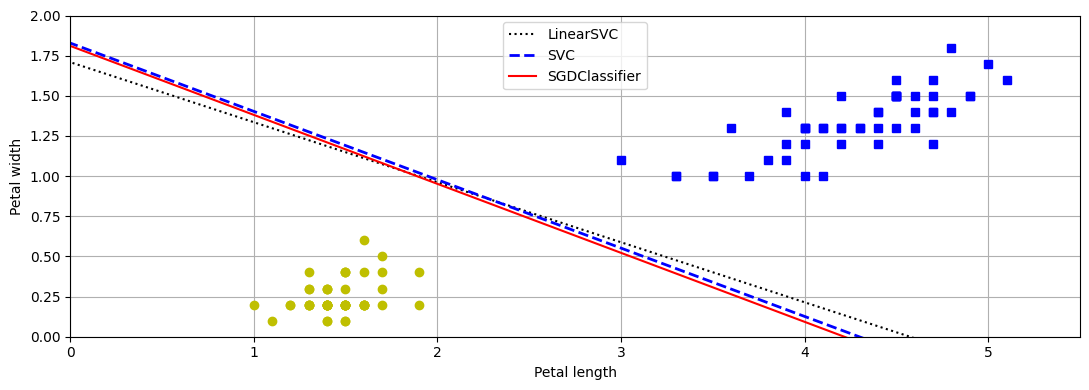

In [9]:
def compute_decision_boundary(model):
    w = -model.coef_[0, 0] / model.coef_[0, 1]
    b = -model.intercept_[0] / model.coef_[0, 1]
    return scaler.inverse_transform([[-10, -10 * w + b], [10, 10 * w + b]])

lin_line = compute_decision_boundary(lin_clf)
svc_line = compute_decision_boundary(svc_clf)
sgd_line = compute_decision_boundary(sgd_clf)

# Plot all three decision boundaries
plt.figure(figsize=(11, 4))
plt.plot(lin_line[:, 0], lin_line[:, 1], "k:", label="LinearSVC")
plt.plot(svc_line[:, 0], svc_line[:, 1], "b--", linewidth=2, label="SVC")
plt.plot(sgd_line[:, 0], sgd_line[:, 1], "r-", label="SGDClassifier")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs") # label="Iris versicolor"
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo") # label="Iris setosa"
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper center")
plt.axis([0, 5.5, 0, 2])
plt.grid()
save_fig("3-models_decision_boundaries")
plt.show()

Close enough!

# 10. SVM classifier on the Wine dataset

_Exercise: Train an SVM classifier on the Wine dataset, which you can load using `sklearn.datasets.load_wine()`. This dataset contains the chemical analysis of 178 wine samples produced by 3 different cultivators: the goal is to train a classification model capable of predicting the cultivator based on the wine's chemical analysis. Since SVM classifiers are binary classifiers, you will need to use one-versus-all to classify all 3 classes. What accuracy can you reach?_

First, let's fetch the dataset, look at its description, then split it into a training set and a test set:

In [10]:
from sklearn.datasets import load_wine

wine = load_wine(as_frame=True)

In [11]:
print(wine.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

:Number of Instances: 178
:Number of Attributes: 13 numeric, predictive attributes and the class
:Attribute Information:
    - Alcohol
    - Malic acid
    - Ash
    - Alcalinity of ash
    - Magnesium
    - Total phenols
    - Flavanoids
    - Nonflavanoid phenols
    - Proanthocyanins
    - Color intensity
    - Hue
    - OD280/OD315 of diluted wines
    - Proline
    - class:
        - class_0
        - class_1
        - class_2

:Summary Statistics:

============================= ==== ===== ======= =====
                                Min   Max   Mean     SD
============================= ==== ===== ======= =====
Alcohol:                      11.0  14.8    13.0   0.8
Malic Acid:                   0.74  5.80    2.34  1.12
Ash:                          1.36  3.23    2.36  0.27
Alcalinity of Ash:            10.6  30.0    19.5   3.3
Magnesium:                    70.0 162.0    99.7  14.3

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    wine.data, wine.target, random_state=42)

In [13]:
X_train.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
100,12.08,2.08,1.70,17.5,97.0,2.23,2.17,0.26,1.40,3.30,1.27,2.96,710.0
122,12.42,4.43,2.73,26.5,102.0,2.20,2.13,0.43,1.71,2.08,0.92,3.12,365.0
154,12.58,1.29,2.10,20.0,103.0,1.48,0.58,0.53,1.40,7.60,0.58,1.55,640.0
51,13.83,1.65,2.60,17.2,94.0,2.45,2.99,0.22,2.29,5.60,1.24,3.37,1265.0


In [14]:
y_train.head()

2      0
100    1
122    1
154    2
51     0
Name: target, dtype: int64

Let's start simple, with a linear SVM classifier. It will automatically use the One-vs-All (also called One-vs-the-Rest, OvR) strategy, so there's nothing special we need to do to handle multiple classes. Easy, right?

In [15]:
lin_clf = LinearSVC(dual=True, random_state=42)
lin_clf.fit(X_train, y_train)

/home/silviojr/.virtualenvs/handson/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(dual=True, random_state=42)

Oh no! It failed to converge. Can you guess why? Do you think we must just increase the number of training iterations? Let's see:

In [16]:
lin_clf = LinearSVC(max_iter=1_000_000, dual=True, random_state=42)
lin_clf.fit(X_train, y_train)

/home/silviojr/.virtualenvs/handson/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(dual=True, max_iter=1000000, random_state=42)

Even with one million iterations, it still did not converge. There must be another problem.

Let's still evaluate this model with `cross_val_score`, it will serve as a baseline:

In [17]:
from sklearn.model_selection import cross_val_score

cross_val_score(lin_clf, X_train, y_train).mean()

/home/silviojr/.virtualenvs/handson/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/silviojr/.virtualenvs/handson/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/silviojr/.virtualenvs/handson/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/silviojr/.virtualenvs/handson/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/silviojr/.virtualenvs/handson/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.90997150997151

Well 91% accuracy on this dataset is not great. So did you guess what the problem is?

That's right, we forgot to scale the features! Always remember to scale the features when using SVMs:

In [18]:
lin_clf = make_pipeline(StandardScaler(),
                        LinearSVC(dual=True, random_state=42))
lin_clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(dual=True, random_state=42))])

Now it converges without any problem. Let's measure its performance:

In [19]:
cross_val_score(lin_clf, X_train, y_train).mean()

0.9774928774928775

Nice! We get 97.7% accuracy, that's much better.

Let's see if a kernelized SVM will do better. We will use a default `SVC` for now:

In [20]:
svm_clf = make_pipeline(StandardScaler(),
                        SVC(random_state=42))
                        
cross_val_score(svm_clf, X_train, y_train).mean()

0.9698005698005698

That's not better, but perhaps we need to do a bit of hyperparameter tuning:

In [21]:
param_distrib = {
    "svc__gamma": loguniform(0.001, 0.1),
    "svc__C": uniform(1, 10)
}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distrib, n_iter=100, cv=5,
                                   random_state=42)
rnd_search_cv.fit(X_train, y_train)
rnd_search_cv.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=9.925589984899778, gamma=0.011986281799901188,
                     random_state=42))])

In [23]:
rnd_search_cv.best_score_

0.9925925925925926

Ah, this looks excellent! Let's select this model. Now we can test it on the test set:

In [24]:
rnd_search_cv.score(X_test, y_test)

0.9777777777777777

This tuned kernelized SVM performs better than the `LinearSVC` model, but we get a lower score on the test set than we measured using cross-validation. This is quite common: since we did so much hyperparameter tuning, we ended up slightly overfitting the cross-validation test sets. It's tempting to tweak the hyperparameters a bit more until we get a better result on the test set, but this would probably not help, as we would just start overfitting the test set. Anyway, this score is not bad at all, so let's stop here.

## 11. - Fine-tuned SVM regressor on the California housing dataset

_Exercise: Train and fine-tune an SVM regressor on the California housing dataset. You can use the original dataset rather than the tweaked version we used in Chapter 2. The original dataset can be fetched using `sklearn.datasets.fetch_california_housing()`. The targets represent hundreds of thousands of dollars. Since there are over 20,000 instances, SVMs can be slow, so for hyperparameter tuning you should use much less instances (e.g., 2,000), to test many more hyperparameter combinations. What is your best model's RMSE?_

Let's load the dataset:

In [25]:
housing = fetch_california_housing()
X = housing.data
y = housing.target

Split it into a training set and a test set:

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

Don't forget to scale the data!

Let's train a simple `LinearSVR` first:

In [29]:
lin_svr = make_pipeline(StandardScaler(),
                        LinearSVR(dual=True, random_state=42))
lin_svr.fit(X_train, y_train)

/home/silviojr/.virtualenvs/handson/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr', LinearSVR(dual=True, random_state=42))])

It did not converge, so let's increase `max_iter`:

In [30]:
lin_svr = make_pipeline(StandardScaler(),
                        LinearSVR(max_iter=5000, dual=True, random_state=42))
lin_svr.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr',
                 LinearSVR(dual=True, max_iter=5000, random_state=42))])

Let's see how it performs on the training set:

In [31]:
y_pred = lin_svr.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
mse

0.9595484665813285

Let's look at the RMSE:

In [32]:
np.sqrt(mse)

0.979565447829459

In this dataset, the targets represent hundreds of thousands of dollars. The RMSE gives a rough idea of the kind of error you should expect (with a higher weight for large errors): so with this model we can expect errors close to $98,000! Not great. Let's see if we can do better with an RBF Kernel. We will use randomized search with cross validation to find the appropriate hyperparameter values for `C` and `gamma`:

In [35]:
svm_clf = make_pipeline(StandardScaler(),
                        SVR())

param_distrib = {
    "svr__gamma": loguniform(0.001, 0.1),
    "svr__C": uniform(1, 10)
}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distrib,
                                   n_iter=100, cv=3, random_state=42)
rnd_search_cv.fit(X_train[:2000], y_train[:2000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('svr', SVR())]),
                   n_iter=100,
                   param_distributions={'svr__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x70d7b2ba9d50>,
                                        'svr__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x70d7b0a52c50>},
                   random_state=42)

In [37]:
rnd_search_cv.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=4.63629602379294, gamma=0.08781408196485979))])

In [38]:
-cross_val_score(rnd_search_cv.best_estimator_, X_train, y_train,
                 scoring="neg_root_mean_squared_error")

array([0.58835648, 0.57468589, 0.58085278, 0.57109886, 0.59853029])

Looks much better than the linear model. Let's select this model and evaluate it on the test set:

In [39]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
rmse

/home/silviojr/.virtualenvs/handson/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0.5854732265172238

So SVMs worked very well on the Wine dataset, but not so much on the California Housing dataset. In Chapter 2, we found that Random Forests worked better for that dataset.